In [1]:
!pip install pyarrow mrjob nltk

In [2]:
%%file solution.py

from mrjob.job import MRJob
from mrjob.step import MRStep
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

import nltk

class MRBigramsCount(MRJob):
    def steps(self):
        return [
            MRStep(
                mapper_init=self.mapper_init,
                mapper=self.mapper,
                combiner=self.combiner,
                reducer=self.reducer1,
            ),
            MRStep(reducer=self.reducer2)
        ]
        
    def mapper_init(self):
        nltk.download('punkt')
        nltk.download('stopwords')

    def mapper(self, _, line):
        splitted = line.split('\" \"')
        line = splitted[-1].strip()[:-1]
        tokenized = word_tokenize(line.lower())
        stop_words = set(stopwords.words('english'))
        filtered_sentence = [w for w in tokenized if (not w in stop_words) and  w.isalnum()]
        for bigram in ngrams(filtered_sentence, 2):
            yield (" ".join(bigram), 1)

    def combiner(self, bigram, counts):
        yield (bigram, sum(counts))

    def reducer1(self, bigram, counts):
        yield None, (sum(counts), bigram)

    def reducer2(self, _, cnt_bigram):
        for cnt, bigram in sorted(cnt_bigram, reverse=True)[:20]:
            yield bigram, cnt
        
if __name__ == "__main__":
    MRBigramsCount.run()

Overwriting solution.py


# Проверяем локально

In [3]:
!python3 solution.py ../SW_EpisodeIV.txt
!python3 solution.py ../SW_EpisodeV.txt
!python3 solution.py ../SW_EpisodeVI.txt
!python3 solution.py ../SW_EpisodeIV.txt ../SW_EpisodeV.txt ../SW_EpisodeIV.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/solution.root.20231128.191710.760387
Running step 1 of 2...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downlo

# Проверяем на кластере

In [4]:
%%file config.conf

runners:
  hadoop:
    setup:
    - pip install nltk

Overwriting config.conf


In [5]:
!python3 solution.py -r hadoop hdfs://namenode:8020/SW_EpisodeIV.txt hdfs://namenode:8020/SW_EpisodeV.txt hdfs://namenode:8020/SW_EpisodeVI.txt --conf-path config.conf

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/solution.root.20231128.191715.700506
uploading working dir files to hdfs:///user/root/tmp/mrjob/solution.root.20231128.191715.700506/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/solution.root.20231128.191715.700506/files/
Running step 1 of 2...
  packageJobJar: [/tmp/hadoop-unjar2845527383070490505/] [] /tmp/streamjob4131255736044809454.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.18.0.5:8032
  Connecting to ResourceManager at resourcemanager/172.18.0.5:8032
  Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1701178253713_0030
  Total input files to process : 3
  number of splits:3
  Submitting tokens for job: job_1701178253

# Строим гистограммы

In [6]:
!pip install matplotlib

In [7]:
import os
from pyarrow import fs
from matplotlib import pyplot as plt

os.environ['CLASSPATH'] = '/opt/hadoop/etc/hadoop:/opt/hadoop/share/hadoop/common/lib/zookeeper-3.6.3.jar:/opt/hadoop/share/hadoop/common/lib/guava-27.0-jre.jar:/opt/hadoop/share/hadoop/common/lib/curator-recipes-5.2.0.jar:/opt/hadoop/share/hadoop/common/lib/dnsjava-2.1.7.jar:/opt/hadoop/share/hadoop/common/lib/listenablefuture-9999.0-empty-to-avoid-conflict-with-guava.jar:/opt/hadoop/share/hadoop/common/lib/kerb-simplekdc-1.0.1.jar:/opt/hadoop/share/hadoop/common/lib/netty-buffer-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/jackson-core-2.12.7.jar:/opt/hadoop/share/hadoop/common/lib/zookeeper-jute-3.6.3.jar:/opt/hadoop/share/hadoop/common/lib/netty-transport-rxtx-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/kerb-crypto-1.0.1.jar:/opt/hadoop/share/hadoop/common/lib/netty-resolver-dns-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/kerb-admin-1.0.1.jar:/opt/hadoop/share/hadoop/common/lib/jul-to-slf4j-1.7.36.jar:/opt/hadoop/share/hadoop/common/lib/slf4j-reload4j-1.7.36.jar:/opt/hadoop/share/hadoop/common/lib/stax2-api-4.2.1.jar:/opt/hadoop/share/hadoop/common/lib/netty-all-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/snappy-java-1.1.8.2.jar:/opt/hadoop/share/hadoop/common/lib/commons-compress-1.21.jar:/opt/hadoop/share/hadoop/common/lib/audience-annotations-0.5.0.jar:/opt/hadoop/share/hadoop/common/lib/checker-qual-2.5.2.jar:/opt/hadoop/share/hadoop/common/lib/metrics-core-3.2.4.jar:/opt/hadoop/share/hadoop/common/lib/netty-handler-proxy-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/jsr311-api-1.1.1.jar:/opt/hadoop/share/hadoop/common/lib/netty-codec-memcache-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/netty-resolver-dns-native-macos-4.1.89.Final-osx-x86_64.jar:/opt/hadoop/share/hadoop/common/lib/kerb-server-1.0.1.jar:/opt/hadoop/share/hadoop/common/lib/jsch-0.1.55.jar:/opt/hadoop/share/hadoop/common/lib/jakarta.activation-api-1.2.1.jar:/opt/hadoop/share/hadoop/common/lib/commons-io-2.8.0.jar:/opt/hadoop/share/hadoop/common/lib/gson-2.9.0.jar:/opt/hadoop/share/hadoop/common/lib/hadoop-auth-3.3.6.jar:/opt/hadoop/share/hadoop/common/lib/jcip-annotations-1.0-1.jar:/opt/hadoop/share/hadoop/common/lib/jackson-annotations-2.12.7.jar:/opt/hadoop/share/hadoop/common/lib/jackson-mapper-asl-1.9.13.jar:/opt/hadoop/share/hadoop/common/lib/animal-sniffer-annotations-1.17.jar:/opt/hadoop/share/hadoop/common/lib/netty-handler-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/protobuf-java-2.5.0.jar:/opt/hadoop/share/hadoop/common/lib/netty-transport-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/commons-codec-1.15.jar:/opt/hadoop/share/hadoop/common/lib/jettison-1.5.4.jar:/opt/hadoop/share/hadoop/common/lib/jersey-json-1.20.jar:/opt/hadoop/share/hadoop/common/lib/jackson-core-asl-1.9.13.jar:/opt/hadoop/share/hadoop/common/lib/jetty-xml-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/common/lib/hadoop-annotations-3.3.6.jar:/opt/hadoop/share/hadoop/common/lib/netty-resolver-dns-native-macos-4.1.89.Final-osx-aarch_64.jar:/opt/hadoop/share/hadoop/common/lib/commons-math3-3.1.1.jar:/opt/hadoop/share/hadoop/common/lib/netty-transport-sctp-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/kerby-xdr-1.0.1.jar:/opt/hadoop/share/hadoop/common/lib/netty-resolver-dns-classes-macos-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/commons-beanutils-1.9.4.jar:/opt/hadoop/share/hadoop/common/lib/netty-transport-udt-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/javax.servlet-api-3.1.0.jar:/opt/hadoop/share/hadoop/common/lib/netty-transport-native-epoll-4.1.89.Final-linux-x86_64.jar:/opt/hadoop/share/hadoop/common/lib/jetty-server-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/common/lib/commons-collections-3.2.2.jar:/opt/hadoop/share/hadoop/common/lib/re2j-1.1.jar:/opt/hadoop/share/hadoop/common/lib/jsp-api-2.1.jar:/opt/hadoop/share/hadoop/common/lib/commons-text-1.10.0.jar:/opt/hadoop/share/hadoop/common/lib/netty-codec-smtp-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/netty-transport-native-unix-common-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/netty-transport-classes-kqueue-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/commons-net-3.9.0.jar:/opt/hadoop/share/hadoop/common/lib/token-provider-1.0.1.jar:/opt/hadoop/share/hadoop/common/lib/avro-1.7.7.jar:/opt/hadoop/share/hadoop/common/lib/httpcore-4.4.13.jar:/opt/hadoop/share/hadoop/common/lib/kerby-util-1.0.1.jar:/opt/hadoop/share/hadoop/common/lib/jersey-core-1.19.4.jar:/opt/hadoop/share/hadoop/common/lib/slf4j-api-1.7.36.jar:/opt/hadoop/share/hadoop/common/lib/commons-configuration2-2.8.0.jar:/opt/hadoop/share/hadoop/common/lib/paranamer-2.3.jar:/opt/hadoop/share/hadoop/common/lib/netty-resolver-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/jetty-util-ajax-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/common/lib/kerb-client-1.0.1.jar:/opt/hadoop/share/hadoop/common/lib/curator-client-5.2.0.jar:/opt/hadoop/share/hadoop/common/lib/netty-codec-socks-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/jetty-security-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/common/lib/jetty-util-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/common/lib/commons-cli-1.2.jar:/opt/hadoop/share/hadoop/common/lib/hadoop-shaded-protobuf_3_7-1.1.1.jar:/opt/hadoop/share/hadoop/common/lib/httpclient-4.5.13.jar:/opt/hadoop/share/hadoop/common/lib/netty-codec-dns-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/netty-transport-native-epoll-4.1.89.Final-linux-aarch_64.jar:/opt/hadoop/share/hadoop/common/lib/curator-framework-5.2.0.jar:/opt/hadoop/share/hadoop/common/lib/netty-transport-native-kqueue-4.1.89.Final-osx-aarch_64.jar:/opt/hadoop/share/hadoop/common/lib/hadoop-shaded-guava-1.1.1.jar:/opt/hadoop/share/hadoop/common/lib/jetty-http-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/common/lib/netty-codec-haproxy-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/netty-handler-ssl-ocsp-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/jersey-servlet-1.19.4.jar:/opt/hadoop/share/hadoop/common/lib/kerby-pkix-1.0.1.jar:/opt/hadoop/share/hadoop/common/lib/jaxb-impl-2.2.3-1.jar:/opt/hadoop/share/hadoop/common/lib/jersey-server-1.19.4.jar:/opt/hadoop/share/hadoop/common/lib/netty-codec-http-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/kerb-core-1.0.1.jar:/opt/hadoop/share/hadoop/common/lib/netty-codec-http2-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/netty-transport-classes-epoll-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/jetty-io-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/common/lib/jetty-servlet-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/common/lib/failureaccess-1.0.jar:/opt/hadoop/share/hadoop/common/lib/jetty-webapp-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/common/lib/kerby-asn1-1.0.1.jar:/opt/hadoop/share/hadoop/common/lib/kerb-common-1.0.1.jar:/opt/hadoop/share/hadoop/common/lib/jsr305-3.0.2.jar:/opt/hadoop/share/hadoop/common/lib/j2objc-annotations-1.1.jar:/opt/hadoop/share/hadoop/common/lib/kerby-config-1.0.1.jar:/opt/hadoop/share/hadoop/common/lib/netty-codec-xml-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/netty-codec-mqtt-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/reload4j-1.2.22.jar:/opt/hadoop/share/hadoop/common/lib/netty-codec-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/woodstox-core-5.4.0.jar:/opt/hadoop/share/hadoop/common/lib/netty-codec-stomp-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/netty-common-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/kerb-util-1.0.1.jar:/opt/hadoop/share/hadoop/common/lib/jackson-databind-2.12.7.1.jar:/opt/hadoop/share/hadoop/common/lib/commons-lang3-3.12.0.jar:/opt/hadoop/share/hadoop/common/lib/commons-daemon-1.0.13.jar:/opt/hadoop/share/hadoop/common/lib/netty-codec-redis-4.1.89.Final.jar:/opt/hadoop/share/hadoop/common/lib/jaxb-api-2.2.11.jar:/opt/hadoop/share/hadoop/common/lib/netty-transport-native-kqueue-4.1.89.Final-osx-x86_64.jar:/opt/hadoop/share/hadoop/common/lib/commons-logging-1.1.3.jar:/opt/hadoop/share/hadoop/common/lib/kerb-identity-1.0.1.jar:/opt/hadoop/share/hadoop/common/lib/nimbus-jose-jwt-9.8.1.jar:/opt/hadoop/share/hadoop/common/hadoop-registry-3.3.6.jar:/opt/hadoop/share/hadoop/common/hadoop-kms-3.3.6.jar:/opt/hadoop/share/hadoop/common/hadoop-nfs-3.3.6.jar:/opt/hadoop/share/hadoop/common/hadoop-common-3.3.6-tests.jar:/opt/hadoop/share/hadoop/common/hadoop-common-3.3.6.jar:/opt/hadoop/share/hadoop/hdfs:/opt/hadoop/share/hadoop/hdfs/lib/zookeeper-3.6.3.jar:/opt/hadoop/share/hadoop/hdfs/lib/guava-27.0-jre.jar:/opt/hadoop/share/hadoop/hdfs/lib/curator-recipes-5.2.0.jar:/opt/hadoop/share/hadoop/hdfs/lib/dnsjava-2.1.7.jar:/opt/hadoop/share/hadoop/hdfs/lib/listenablefuture-9999.0-empty-to-avoid-conflict-with-guava.jar:/opt/hadoop/share/hadoop/hdfs/lib/kerb-simplekdc-1.0.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-buffer-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/jackson-core-2.12.7.jar:/opt/hadoop/share/hadoop/hdfs/lib/zookeeper-jute-3.6.3.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-transport-rxtx-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/kerb-crypto-1.0.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-resolver-dns-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/kerb-admin-1.0.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/stax2-api-4.2.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-all-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/snappy-java-1.1.8.2.jar:/opt/hadoop/share/hadoop/hdfs/lib/commons-compress-1.21.jar:/opt/hadoop/share/hadoop/hdfs/lib/audience-annotations-0.5.0.jar:/opt/hadoop/share/hadoop/hdfs/lib/checker-qual-2.5.2.jar:/opt/hadoop/share/hadoop/hdfs/lib/metrics-core-3.2.4.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-handler-proxy-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/jsr311-api-1.1.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/kotlin-stdlib-1.4.10.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-codec-memcache-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-resolver-dns-native-macos-4.1.89.Final-osx-x86_64.jar:/opt/hadoop/share/hadoop/hdfs/lib/kerb-server-1.0.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/jsch-0.1.55.jar:/opt/hadoop/share/hadoop/hdfs/lib/jakarta.activation-api-1.2.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/commons-io-2.8.0.jar:/opt/hadoop/share/hadoop/hdfs/lib/gson-2.9.0.jar:/opt/hadoop/share/hadoop/hdfs/lib/hadoop-auth-3.3.6.jar:/opt/hadoop/share/hadoop/hdfs/lib/jcip-annotations-1.0-1.jar:/opt/hadoop/share/hadoop/hdfs/lib/jackson-annotations-2.12.7.jar:/opt/hadoop/share/hadoop/hdfs/lib/jackson-mapper-asl-1.9.13.jar:/opt/hadoop/share/hadoop/hdfs/lib/animal-sniffer-annotations-1.17.jar:/opt/hadoop/share/hadoop/hdfs/lib/json-simple-1.1.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-handler-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/protobuf-java-2.5.0.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-transport-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/commons-codec-1.15.jar:/opt/hadoop/share/hadoop/hdfs/lib/jettison-1.5.4.jar:/opt/hadoop/share/hadoop/hdfs/lib/leveldbjni-all-1.8.jar:/opt/hadoop/share/hadoop/hdfs/lib/jersey-json-1.20.jar:/opt/hadoop/share/hadoop/hdfs/lib/jackson-core-asl-1.9.13.jar:/opt/hadoop/share/hadoop/hdfs/lib/jetty-xml-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/hdfs/lib/hadoop-annotations-3.3.6.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-resolver-dns-native-macos-4.1.89.Final-osx-aarch_64.jar:/opt/hadoop/share/hadoop/hdfs/lib/commons-math3-3.1.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-transport-sctp-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/kerby-xdr-1.0.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-resolver-dns-classes-macos-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/commons-beanutils-1.9.4.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-transport-udt-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/javax.servlet-api-3.1.0.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-transport-native-epoll-4.1.89.Final-linux-x86_64.jar:/opt/hadoop/share/hadoop/hdfs/lib/jetty-server-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/hdfs/lib/commons-collections-3.2.2.jar:/opt/hadoop/share/hadoop/hdfs/lib/re2j-1.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/commons-text-1.10.0.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-codec-smtp-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-transport-native-unix-common-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-transport-classes-kqueue-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/commons-net-3.9.0.jar:/opt/hadoop/share/hadoop/hdfs/lib/token-provider-1.0.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/avro-1.7.7.jar:/opt/hadoop/share/hadoop/hdfs/lib/kotlin-stdlib-common-1.4.10.jar:/opt/hadoop/share/hadoop/hdfs/lib/httpcore-4.4.13.jar:/opt/hadoop/share/hadoop/hdfs/lib/kerby-util-1.0.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/jersey-core-1.19.4.jar:/opt/hadoop/share/hadoop/hdfs/lib/commons-configuration2-2.8.0.jar:/opt/hadoop/share/hadoop/hdfs/lib/paranamer-2.3.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-resolver-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/jetty-util-ajax-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/hdfs/lib/kerb-client-1.0.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/curator-client-5.2.0.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-codec-socks-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/jetty-security-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/hdfs/lib/okhttp-4.9.3.jar:/opt/hadoop/share/hadoop/hdfs/lib/jetty-util-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/hdfs/lib/commons-cli-1.2.jar:/opt/hadoop/share/hadoop/hdfs/lib/hadoop-shaded-protobuf_3_7-1.1.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/HikariCP-java7-2.4.12.jar:/opt/hadoop/share/hadoop/hdfs/lib/httpclient-4.5.13.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-codec-dns-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-transport-native-epoll-4.1.89.Final-linux-aarch_64.jar:/opt/hadoop/share/hadoop/hdfs/lib/curator-framework-5.2.0.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-transport-native-kqueue-4.1.89.Final-osx-aarch_64.jar:/opt/hadoop/share/hadoop/hdfs/lib/hadoop-shaded-guava-1.1.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/jetty-http-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-codec-haproxy-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-handler-ssl-ocsp-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-3.10.6.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/jersey-servlet-1.19.4.jar:/opt/hadoop/share/hadoop/hdfs/lib/kerby-pkix-1.0.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/jaxb-impl-2.2.3-1.jar:/opt/hadoop/share/hadoop/hdfs/lib/jersey-server-1.19.4.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-codec-http-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/kerb-core-1.0.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-codec-http2-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-transport-classes-epoll-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/jetty-io-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/hdfs/lib/jetty-servlet-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/hdfs/lib/failureaccess-1.0.jar:/opt/hadoop/share/hadoop/hdfs/lib/jetty-webapp-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/hdfs/lib/kerby-asn1-1.0.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/kerb-common-1.0.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/jsr305-3.0.2.jar:/opt/hadoop/share/hadoop/hdfs/lib/j2objc-annotations-1.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/kerby-config-1.0.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-codec-xml-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-codec-mqtt-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/reload4j-1.2.22.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-codec-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/woodstox-core-5.4.0.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-codec-stomp-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-common-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/kerb-util-1.0.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/jackson-databind-2.12.7.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/commons-lang3-3.12.0.jar:/opt/hadoop/share/hadoop/hdfs/lib/commons-daemon-1.0.13.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-codec-redis-4.1.89.Final.jar:/opt/hadoop/share/hadoop/hdfs/lib/jaxb-api-2.2.11.jar:/opt/hadoop/share/hadoop/hdfs/lib/netty-transport-native-kqueue-4.1.89.Final-osx-x86_64.jar:/opt/hadoop/share/hadoop/hdfs/lib/okio-2.8.0.jar:/opt/hadoop/share/hadoop/hdfs/lib/commons-logging-1.1.3.jar:/opt/hadoop/share/hadoop/hdfs/lib/kerb-identity-1.0.1.jar:/opt/hadoop/share/hadoop/hdfs/lib/nimbus-jose-jwt-9.8.1.jar:/opt/hadoop/share/hadoop/hdfs/hadoop-hdfs-client-3.3.6.jar:/opt/hadoop/share/hadoop/hdfs/hadoop-hdfs-3.3.6.jar:/opt/hadoop/share/hadoop/hdfs/hadoop-hdfs-native-client-3.3.6-tests.jar:/opt/hadoop/share/hadoop/hdfs/hadoop-hdfs-3.3.6-tests.jar:/opt/hadoop/share/hadoop/hdfs/hadoop-hdfs-nfs-3.3.6.jar:/opt/hadoop/share/hadoop/hdfs/hadoop-hdfs-client-3.3.6-tests.jar:/opt/hadoop/share/hadoop/hdfs/hadoop-hdfs-httpfs-3.3.6.jar:/opt/hadoop/share/hadoop/hdfs/hadoop-hdfs-rbf-3.3.6-tests.jar:/opt/hadoop/share/hadoop/hdfs/hadoop-hdfs-native-client-3.3.6.jar:/opt/hadoop/share/hadoop/hdfs/hadoop-hdfs-rbf-3.3.6.jar:/opt/hadoop/share/hadoop/mapreduce/hadoop-mapreduce-client-common-3.3.6.jar:/opt/hadoop/share/hadoop/mapreduce/hadoop-mapreduce-examples-3.3.6.jar:/opt/hadoop/share/hadoop/mapreduce/hadoop-mapreduce-client-hs-plugins-3.3.6.jar:/opt/hadoop/share/hadoop/mapreduce/hadoop-mapreduce-client-app-3.3.6.jar:/opt/hadoop/share/hadoop/mapreduce/hadoop-mapreduce-client-uploader-3.3.6.jar:/opt/hadoop/share/hadoop/mapreduce/hadoop-mapreduce-client-core-3.3.6.jar:/opt/hadoop/share/hadoop/mapreduce/hadoop-mapreduce-client-jobclient-3.3.6.jar:/opt/hadoop/share/hadoop/mapreduce/hadoop-mapreduce-client-nativetask-3.3.6.jar:/opt/hadoop/share/hadoop/mapreduce/hadoop-mapreduce-client-jobclient-3.3.6-tests.jar:/opt/hadoop/share/hadoop/mapreduce/hadoop-mapreduce-client-shuffle-3.3.6.jar:/opt/hadoop/share/hadoop/mapreduce/hadoop-mapreduce-client-hs-3.3.6.jar:/opt/hadoop/share/hadoop/yarn:/opt/hadoop/share/hadoop/yarn/lib/jetty-client-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/yarn/lib/jetty-annotations-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/yarn/lib/websocket-common-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/yarn/lib/objenesis-2.6.jar:/opt/hadoop/share/hadoop/yarn/lib/jline-3.9.0.jar:/opt/hadoop/share/hadoop/yarn/lib/jetty-jndi-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/yarn/lib/jersey-client-1.19.4.jar:/opt/hadoop/share/hadoop/yarn/lib/javax.inject-1.jar:/opt/hadoop/share/hadoop/yarn/lib/java-util-1.9.0.jar:/opt/hadoop/share/hadoop/yarn/lib/javax-websocket-server-impl-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/yarn/lib/jackson-jaxrs-base-2.12.7.jar:/opt/hadoop/share/hadoop/yarn/lib/jackson-jaxrs-json-provider-2.12.7.jar:/opt/hadoop/share/hadoop/yarn/lib/swagger-annotations-1.5.4.jar:/opt/hadoop/share/hadoop/yarn/lib/mssql-jdbc-6.2.1.jre7.jar:/opt/hadoop/share/hadoop/yarn/lib/websocket-client-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/yarn/lib/jakarta.xml.bind-api-2.3.2.jar:/opt/hadoop/share/hadoop/yarn/lib/jackson-module-jaxb-annotations-2.12.7.jar:/opt/hadoop/share/hadoop/yarn/lib/javax-websocket-client-impl-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/yarn/lib/javax.websocket-api-1.0.jar:/opt/hadoop/share/hadoop/yarn/lib/bcprov-jdk15on-1.68.jar:/opt/hadoop/share/hadoop/yarn/lib/websocket-servlet-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/yarn/lib/jna-5.2.0.jar:/opt/hadoop/share/hadoop/yarn/lib/jersey-guice-1.19.4.jar:/opt/hadoop/share/hadoop/yarn/lib/json-io-2.5.1.jar:/opt/hadoop/share/hadoop/yarn/lib/asm-commons-9.4.jar:/opt/hadoop/share/hadoop/yarn/lib/websocket-api-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/yarn/lib/geronimo-jcache_1.0_spec-1.0-alpha-1.jar:/opt/hadoop/share/hadoop/yarn/lib/guice-4.0.jar:/opt/hadoop/share/hadoop/yarn/lib/aopalliance-1.0.jar:/opt/hadoop/share/hadoop/yarn/lib/jetty-plus-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/yarn/lib/guice-servlet-4.0.jar:/opt/hadoop/share/hadoop/yarn/lib/bcpkix-jdk15on-1.68.jar:/opt/hadoop/share/hadoop/yarn/lib/websocket-server-9.4.51.v20230217.jar:/opt/hadoop/share/hadoop/yarn/lib/snakeyaml-2.0.jar:/opt/hadoop/share/hadoop/yarn/lib/asm-tree-9.4.jar:/opt/hadoop/share/hadoop/yarn/lib/fst-2.50.jar:/opt/hadoop/share/hadoop/yarn/lib/ehcache-3.3.1.jar:/opt/hadoop/share/hadoop/yarn/lib/javax.websocket-client-api-1.0.jar:/opt/hadoop/share/hadoop/yarn/hadoop-yarn-registry-3.3.6.jar:/opt/hadoop/share/hadoop/yarn/hadoop-yarn-server-timeline-pluginstorage-3.3.6.jar:/opt/hadoop/share/hadoop/yarn/hadoop-yarn-api-3.3.6.jar:/opt/hadoop/share/hadoop/yarn/hadoop-yarn-services-api-3.3.6.jar:/opt/hadoop/share/hadoop/yarn/hadoop-yarn-server-web-proxy-3.3.6.jar:/opt/hadoop/share/hadoop/yarn/hadoop-yarn-common-3.3.6.jar:/opt/hadoop/share/hadoop/yarn/hadoop-yarn-server-router-3.3.6.jar:/opt/hadoop/share/hadoop/yarn/hadoop-yarn-applications-mawo-core-3.3.6.jar:/opt/hadoop/share/hadoop/yarn/hadoop-yarn-server-applicationhistoryservice-3.3.6.jar:/opt/hadoop/share/hadoop/yarn/hadoop-yarn-server-common-3.3.6.jar:/opt/hadoop/share/hadoop/yarn/hadoop-yarn-server-tests-3.3.6.jar:/opt/hadoop/share/hadoop/yarn/hadoop-yarn-server-sharedcachemanager-3.3.6.jar:/opt/hadoop/share/hadoop/yarn/hadoop-yarn-client-3.3.6.jar:/opt/hadoop/share/hadoop/yarn/hadoop-yarn-server-nodemanager-3.3.6.jar:/opt/hadoop/share/hadoop/yarn/hadoop-yarn-server-resourcemanager-3.3.6.jar:/opt/hadoop/share/hadoop/yarn/hadoop-yarn-applications-distributedshell-3.3.6.jar:/opt/hadoop/share/hadoop/yarn/hadoop-yarn-applications-unmanaged-am-launcher-3.3.6.jar:/opt/hadoop/share/hadoop/yarn/hadoop-yarn-services-core-3.3.6.jar'
hdfs = fs.HadoopFileSystem("namenode", 8020)

def histogram(filename: str):
    with hdfs.open_input_stream(filename) as file:
        data = file.readall().decode("utf-8")
        names = []
        counts = []
        for line in data.split("\n"):
            splitted  = line.strip().split("\t")
            name = splitted[0]
            cnt = splitted[-1]
            if name == "":
                break
            names.append(name)
            counts.append(int(cnt))
        plt.barh(names, counts)
        plt.show()

In [8]:
!python3 solution.py -r hadoop hdfs://namenode:8020/SW_EpisodeIV.txt --conf-path config.conf --output /t3_e4

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/solution.root.20231128.191818.907783
uploading working dir files to hdfs:///user/root/tmp/mrjob/solution.root.20231128.191818.907783/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/solution.root.20231128.191818.907783/files/
Running step 1 of 2...
  packageJobJar: [/tmp/hadoop-unjar3217722673099908440/] [] /tmp/streamjob57350979642027043.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.18.0.5:8032
  Connecting to ResourceManager at resourcemanager/172.18.0.5:8032
  Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1701178253713_0032
  Total input files to process : 1
  number of splits:2
  Submitting tokens for job: job_170117825371

In [9]:
!python3 solution.py -r hadoop hdfs://namenode:8020/SW_EpisodeV.txt --conf-path config.conf --output /t3_e5

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/solution.root.20231128.191910.439058
uploading working dir files to hdfs:///user/root/tmp/mrjob/solution.root.20231128.191910.439058/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/solution.root.20231128.191910.439058/files/
Running step 1 of 2...
  packageJobJar: [/tmp/hadoop-unjar6196973321622418231/] [] /tmp/streamjob2092873137169157481.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.18.0.5:8032
  Connecting to ResourceManager at resourcemanager/172.18.0.5:8032
  Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1701178253713_0034
  Total input files to process : 1
  number of splits:2
  Submitting tokens for job: job_1701178253

In [10]:
!python3 solution.py -r hadoop hdfs://namenode:8020/SW_EpisodeVI.txt --conf-path config.conf --output /t3_e6

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/solution.root.20231128.192005.844856
uploading working dir files to hdfs:///user/root/tmp/mrjob/solution.root.20231128.192005.844856/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/solution.root.20231128.192005.844856/files/
Running step 1 of 2...
  packageJobJar: [/tmp/hadoop-unjar7186711963506436011/] [] /tmp/streamjob8091373911489452182.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.18.0.5:8032
  Connecting to ResourceManager at resourcemanager/172.18.0.5:8032
  Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1701178253713_0036
  Total input files to process : 1
  number of splits:2
  Submitting tokens for job: job_1701178253

In [11]:
!python3 solution.py -r hadoop hdfs://namenode:8020/SW_EpisodeIV.txt hdfs://namenode:8020/SW_EpisodeV.txt hdfs://namenode:8020/SW_EpisodeVI.txt --output /t3_all

No configs found; falling back on auto-configuration
No configs specified for hadoop runner
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/solution.root.20231128.192059.122744
uploading working dir files to hdfs:///user/root/tmp/mrjob/solution.root.20231128.192059.122744/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/solution.root.20231128.192059.122744/files/
Running step 1 of 2...
  packageJobJar: [/tmp/hadoop-unjar4881366821249516474/] [] /tmp/streamjob3492972769342896928.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.18.0.5:8032
  Connecting to ResourceManager at resourcemanager/172.18.0.5:8032
  Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1701178253713_0038
  Total

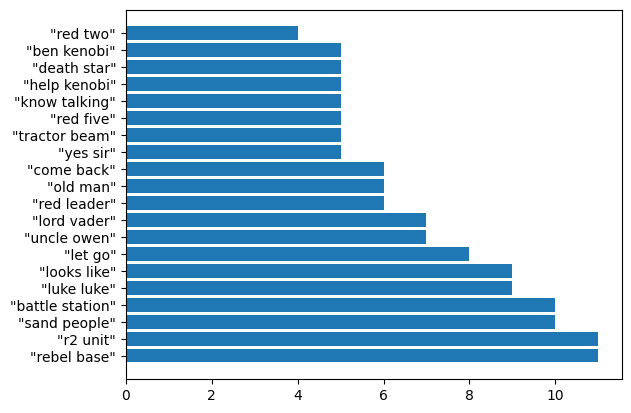

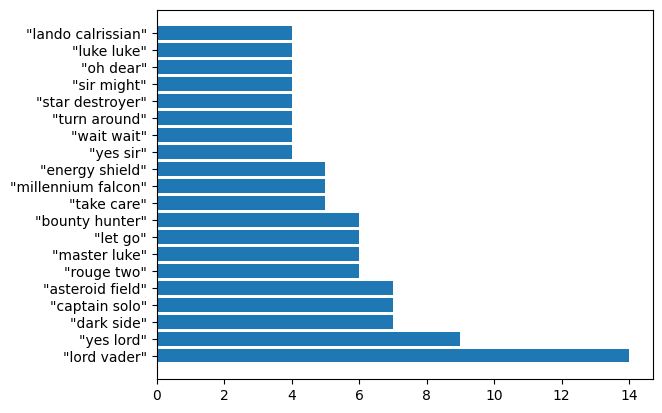

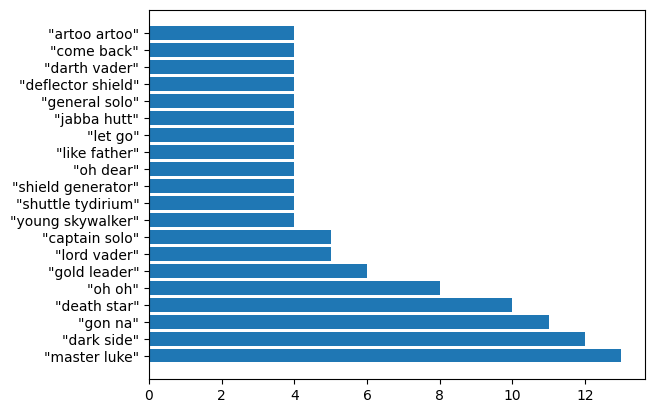

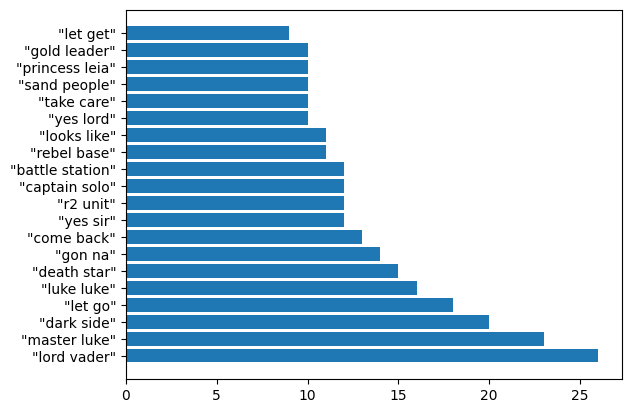

In [12]:
histogram("/t3_e4/part-00000")
histogram("/t3_e5/part-00000")
histogram("/t3_e6/part-00000")
histogram("/t3_all/part-00000")